In [1]:
# general libraries
import os 
import gdown 
import logging
import random
import shutil
import numpy as np 
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

# torch libraries
import torch 
import torch.nn as nn 
import torchvision

from torch.utils.tensorboard.writer import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchinfo import summary

# now info
now = datetime.now().strftime("%a, %d %b %Y %H:%M:%S")
datetime_str = datetime.now().strftime("%Y%m%d_%H%M%S")
date_str = datetime.now().strftime("%Y%m%d")

# current directory
current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)

# project folder name
project_folder_dir = f"06_feature_extraction_transfer_learning_{date_str}"

# project name
project_folder_name = f"06_feature_extraction_transfer_learning_{datetime_str}"

# data directory
DATA_DIR = Path(current_dir).joinpath('../../data/')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

# logs directory
LOG_DIR = Path(current_dir).joinpath(f'../../logs/{project_folder_dir}')
if not LOG_DIR.is_dir():
    LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}.log")
PREDICTED_RESULTS_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}.png")
PREDICTED_RESULTS_LOADED_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_loaded.png")
HISTORY_CURVES_FILE_PATH = LOG_DIR.joinpath(f"{project_folder_name}_history_curves.png")

# models directory
MODEL_DIR = Path(current_dir).joinpath(f'../../models/{project_folder_dir}')
if not MODEL_DIR.is_dir():
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_FILE_PATH = MODEL_DIR.joinpath(f"{project_folder_name}.pt")


# logging configuration
logging.basicConfig(
    level=logging.INFO,
    datefmt="%a, %d %b %Y, %H:%m:%S",
    format="[%(asctime)s.%(msecs)03d] %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename=LOG_FILE_PATH, mode="w"),
        logging.StreamHandler()
    ]
)

## info displaying
# created date
logging.info(f"Created date: Tue, 29 Aug 2023 17:54:03")

# modified date 
logging.info(f"Modified date: {now}")

# torch version
logging.info(f"Torch version: {torch.__version__}")

# torchvision version
logging.info(f"Torchvision version: {torchvision.__version__}")

# Number of GPUs
num_gpus = torch.cuda.device_count()
logging.info(f"Num GPUs: {num_gpus}")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Device: {device}")

# Cuda version
logging.info(f"Cuda version: {torch.version.cuda}")

## download data
# download 
DATASET_URL = "https://drive.google.com/uc?id=1Vf1AzPKPY3kYxt3sehkSTnggxr-9556Z"
DATASET_ZIPFILE_NAME = "10_food_classes_1_percent.zip"
DATASET_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_ZIPFILE_NAME)
if not DATASET_ZIPFILE_PATH.is_file():
    logging.info(f"The {DATASET_ZIPFILE_NAME} is downloading...")
    try:
        gdown.download(url=DATASET_URL, output=str(DATASET_ZIPFILE_PATH))
        logging.info(f"The {DATASET_ZIPFILE_NAME} is downloaded successfully.")
    except Exception as error:
        logging.error(f"Caught this error: {error} during downloading.")
else:
    logging.info(f"The `{DATASET_ZIPFILE_NAME}` folder already exists.")

# extract the zipfile
DATASET_FOLDER_NAME = "10_food_classes_1_percent"
DATASET_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FOLDER_NAME)
if not DATASET_FOLDER_PATH.is_dir():
    logging.info(f"The {DATASET_ZIPFILE_NAME} is extracting...")
    try:
        gdown.extractall(path=str(DATASET_ZIPFILE_PATH), to=str(DATA_DIR))
        logging.info(f"The {DATASET_ZIPFILE_NAME} is extracted successfully.")

        # delete the zipfile
        # os.remove(path=str(DATASET_ZIPFILE_PATH))
        
    except Exception as error:
        logging.error(f"Caught this error: {error} during extracting.")
else: 
     logging.info(f"The `{DATASET_FOLDER_NAME}` folder already exists.")

/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[Thu, 31 Aug 2023, 16:08:58.946] INFO - Created date: Tue, 29 Aug 2023 17:54:03
[Thu, 31 Aug 2023, 16:08:58.946] INFO - Modified date: Thu, 31 Aug 2023 16:04:58
[Thu, 31 Aug 2023, 16:08:58.947] INFO - Torch version: 1.12.1
[Thu, 31 Aug 2023, 16:08:58.947] INFO - Torchvision version: 0.13.1
[Thu, 31 Aug 2023, 16:08:58.953] INFO - Num GPUs: 1
[Thu, 31 Aug 2023, 16:08:58.954] INFO - Device: cuda
[Thu, 31 Aug 2023, 16:08:58.954] INFO - Cuda version: 11.3
[Thu, 31 Aug 2023, 16:08:58.956] INFO - The `10_food_classes_1_percent.zip` folder already exists.
[Thu, 31 Aug 2023, 16:08:58.956] INFO - The `10_food_classes_1_percent` folder already exists.


In [2]:
def create_validation_data(dataset_dir: Path, val_dir: str, ratio: int = 0.2):
    if not dataset_dir.is_dir():
        logging.info(f"The directory is not found. Please check it before continuing.")
        exit()
    else:
        logging.info(f"Start splitting the dataset directory into `train_dir` and `val_dir`.")
        
        # all class names
        dir_names = os.listdir(dataset_dir)
        
        # split to train, val
        for dir_name in dir_names:

            class_dir = dataset_dir.joinpath(dir_name)
            val_class_dir = val_dir.joinpath(dir_name)

            if not val_class_dir.is_dir():
                val_class_dir.mkdir(parents=True, exist_ok=True)

            class_file_paths =[entry.path for entry in list(os.scandir(class_dir))]
            sub_file_paths = random.sample(class_file_paths, int(ratio * len(class_file_paths)))
            
            for sub_file_path in sub_file_paths:
                shutil.copy(sub_file_path, val_class_dir)

        logging.info(f"Splitting the dataset directory into `train_dir` and `val_dir` has done.")

# train dir
dataset_dir = DATASET_FOLDER_PATH.joinpath("train")
train_dir = DATASET_FOLDER_PATH.joinpath("train")
test_dir = DATASET_FOLDER_PATH.joinpath("test")

# val dir
val_dir = DATASET_FOLDER_PATH.joinpath("val")
if not val_dir.is_dir():
    logging.info(f"Validation data is creating...")
    val_dir.mkdir(parents=True, exist_ok=True)

    # create a validation data
    create_validation_data(dataset_dir=dataset_dir, val_dir=val_dir)
else:
     logging.info(f"Validation data already exists.")

[Thu, 31 Aug 2023, 16:08:58.965] INFO - Validation data already exists.


In [3]:
# walk through training directory
for filepaths, dirnames, filenames in os.walk(str(train_dir)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths}")

[Thu, 31 Aug 2023, 16:08:58.975] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/pizza
[Thu, 31 Aug 2023, 16:08:58.976] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/steak
[Thu, 31 Aug 2023, 16:08:58.976] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/ice_cream
[Thu, 31 Aug 2023, 16:08:58.977] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/sushi
[Thu, 31 Aug 2023, 16:08:58.977] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/chicken_wings
[Thu, 31 Aug 2023, 16:08:58.978] INFO - There are 7 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/train/chicken_curry
[Thu, 31 Aug 2023, 16:08:58.978]

In [4]:
# walk through testing directory
for filepaths, dirnames, filenames in os.walk(str(test_dir)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths}")

[Thu, 31 Aug 2023, 16:08:58.985] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/pizza
[Thu, 31 Aug 2023, 16:08:58.986] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/steak
[Thu, 31 Aug 2023, 16:08:58.987] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/ice_cream
[Thu, 31 Aug 2023, 16:08:58.988] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/sushi
[Thu, 31 Aug 2023, 16:08:58.989] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/chicken_wings
[Thu, 31 Aug 2023, 16:08:58.990] INFO - There are 250 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/test/chicken_curry
[Thu, 31 Aug 2023, 16:08:5

In [5]:
# walk through validation directory
for filepaths, dirnames, filenames in os.walk(str(val_dir)):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} images in {filepaths}")

[Thu, 31 Aug 2023, 16:08:58.997] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/pizza
[Thu, 31 Aug 2023, 16:08:58.997] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/steak
[Thu, 31 Aug 2023, 16:08:58.998] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/ice_cream
[Thu, 31 Aug 2023, 16:08:58.999] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/sushi
[Thu, 31 Aug 2023, 16:08:58.999] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/chicken_wings
[Thu, 31 Aug 2023, 16:08:58.999] INFO - There are 1 images in /home/jason/Documents/TADAC/pdl/tadac/practice/../../data/10_food_classes_1_percent/val/chicken_curry
[Thu, 31 Aug 2023, 16:08:59.000] INFO - Ther

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.225, 0.224])
])

test_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.225, 0.224])
])

val_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.225, 0.224])
])


# train dataset
train_dataset = ImageFolder(train_dir, transform= train_transform)

# test dataset
test_dataset = ImageFolder(test_dir, transform= test_transform)

# val dataset
val_dataset = ImageFolder(val_dir, transform= val_transform)

# length of training set
logging.info(f"len(train_dataset): {len(train_dataset)}")

# length of test set
logging.info(f"len(test_dataset): {len(test_dataset)}")

# length of val set
logging.info(f"len(val_dataset): {len(val_dataset)}")

[Thu, 31 Aug 2023, 16:08:59.015] INFO - len(train_dataset): 70
[Thu, 31 Aug 2023, 16:08:59.015] INFO - len(test_dataset): 2500
[Thu, 31 Aug 2023, 16:08:59.016] INFO - len(val_dataset): 10


In [7]:
# class names
class_names = train_dataset.classes
class_names

logging.info(f"Class names: {class_names}")

[Thu, 31 Aug 2023, 16:08:59.020] INFO - Class names: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [8]:
# batch size
batch_size = 32
logging.info(f"Batch size: {batch_size}")

# epochs
inital_epochs = 25
logging.info(f"Epochs: {inital_epochs}")

# num of workers
num_workers = os.cpu_count()
logging.info(f"Number of workers: {num_workers}")

[Thu, 31 Aug 2023, 16:08:59.027] INFO - Batch size: 32
[Thu, 31 Aug 2023, 16:08:59.027] INFO - Epochs: 25
[Thu, 31 Aug 2023, 16:08:59.028] INFO - Number of workers: 12


In [9]:
# train dataloader
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers= num_workers)

# test dataloader
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False, num_workers= num_workers)

# val dataloader
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle=True, num_workers= num_workers)

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd95c4f56a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd95c4f5fa0>)

In [10]:
def create_model(class_names: list, device: str) -> nn.Module:

    # get the pretrained weights
    efficientnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

    # load the pretrained model
    model = torchvision.models.efficientnet_b0(weights=efficientnet_weights)
    
    # freezing features from the pretrained model
    for param in model.parameters():
        param.requires_grad = False

    # adjust the classifier
    model.classifier = nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(in_features=1280, out_features=len(class_names))
    )

    # summary again after freezing the pretrained weights
    summary(model=model,
            input_size=(32, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=25,
            row_settings=["var_names"])
    
    # data parallel
    if num_gpus > 1:
        model = torch.nn.parallel.DataParallel(module=model, device_ids=list(range(num_gpus)))
    model.to(device)


    return model

#### Feature Extraction - Transfer Learning

In [11]:
# history dict
history_dict = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": []
}

# create a model
efficientnet_model = create_model(class_names=class_names, device=device)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adam(params=efficientnet_model.parameters(), lr= 0.001)

## TRAINING 
for epoch in range(inital_epochs):

    accumulated_train_loss = 0.0
    accumulated_train_accuracy = 0.0
    accumulated_train_batches = 0

    for inputs, outputs in train_dataloader:

        # training mode
        efficientnet_model.train()

        # send data to device
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        # forward 
        y_logits = efficientnet_model(inputs)

        # calculate loss
        loss = loss_fn(y_logits, outputs)
        accumulated_train_loss += loss

        # calculate accuracy
        acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_accuracy += (acc / len(y_logits))

        # zero gradients
        optimizer.zero_grad()

        # backward 
        loss.backward()

        # update weights
        optimizer.step()

        # update batches
        accumulated_train_batches += 1

    
    ## EVALUATION
    # evaluation mode
    efficientnet_model.eval()
    with torch.inference_mode():
        accumulated_test_loss = 0.0
        accumulated_test_accuracy = 0.0
        accumulated_test_batches = 0

        for inputs, outputs in train_dataloader:

            # send data to device
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            # forward 
            y_logits = efficientnet_model(inputs)

            # calculate loss
            loss = loss_fn(y_logits, outputs)
            accumulated_test_loss += loss

            # calculate accuracy
            acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_accuracy += (acc / len(y_logits))

            # update batches
            accumulated_test_batches += 1
    
    # training
    accuracy = accumulated_train_accuracy / accumulated_train_batches
    loss = accumulated_train_loss / accumulated_train_batches

    # evaluating
    val_accuracy = accumulated_test_accuracy / accumulated_test_batches
    val_loss = accumulated_test_loss / accumulated_test_batches

    # history dict
    history_dict["val_accuracy"].append(round(val_accuracy, 3))
    history_dict["val_loss"].append(round(val_loss.cpu().numpy().item(), 4))

    # print out 
    logging.info(f"Epoch: {epoch + 1} / {inital_epochs} | accuracy: {accuracy: .3f} | loss: {loss: .4f} | val_accuracy: {val_accuracy: .3f} | val_loss: {val_loss: .4f} ")

# save model
torch.save(efficientnet_model, MODEL_FILE_PATH)

[Thu, 31 Aug 2023, 16:08:02.559] INFO - Epoch: 1 / 25 | accuracy:  0.094 | loss:  2.3499 | val_accuracy:  0.201 | val_loss:  2.2581 
[Thu, 31 Aug 2023, 16:08:03.699] INFO - Epoch: 2 / 25 | accuracy:  0.288 | loss:  2.1772 | val_accuracy:  0.420 | val_loss:  2.1004 
[Thu, 31 Aug 2023, 16:08:04.862] INFO - Epoch: 3 / 25 | accuracy:  0.403 | loss:  2.1575 | val_accuracy:  0.590 | val_loss:  1.9490 
[Thu, 31 Aug 2023, 16:08:05.954] INFO - Epoch: 4 / 25 | accuracy:  0.413 | loss:  2.0906 | val_accuracy:  0.594 | val_loss:  1.8908 
[Thu, 31 Aug 2023, 16:08:07.104] INFO - Epoch: 5 / 25 | accuracy:  0.424 | loss:  1.9678 | val_accuracy:  0.691 | val_loss:  1.8133 
[Thu, 31 Aug 2023, 16:08:08.253] INFO - Epoch: 6 / 25 | accuracy:  0.549 | loss:  1.8764 | val_accuracy:  0.712 | val_loss:  1.7786 
[Thu, 31 Aug 2023, 16:08:09.416] INFO - Epoch: 7 / 25 | accuracy:  0.726 | loss:  1.7783 | val_accuracy:  0.691 | val_loss:  1.7585 
[Thu, 31 Aug 2023, 16:08:10.649] INFO - Epoch: 8 / 25 | accuracy:  0.

[Thu, 31 Aug 2023, 16:08:30.508] INFO - images.shape: torch.Size([10, 3, 224, 224])
[Thu, 31 Aug 2023, 16:08:30.509] INFO - labels.shape: torch.Size([10])


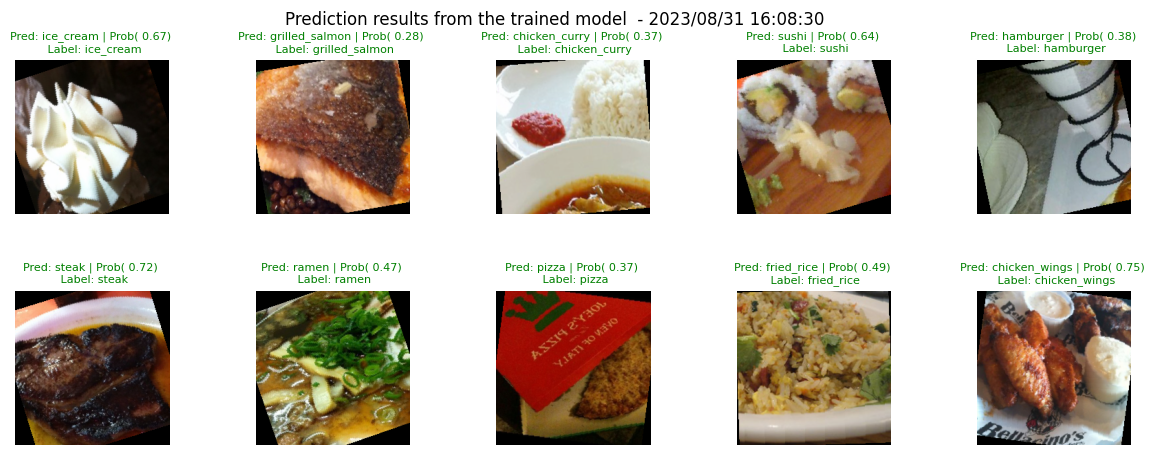

In [12]:
# one batch of val_dataloader
images, labels = next(iter(val_dataloader))

logging.info(f"images.shape: {images.shape}")
logging.info(f"labels.shape: {labels.shape}")

# evaluate the model with val dataset
efficientnet_model.eval()
with torch.inference_mode():
    y_logits = efficientnet_model(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()
    y_probs, _ = torch.max(torch.softmax(y_logits, dim=1), dim=1)
    y_probs = y_probs.cpu().numpy()



# visualize images
plt.figure(figsize=(15,5))
plt.suptitle(f"Prediction results from the trained model  - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplots_adjust(hspace=0.5)
for i, image in enumerate(images):
    plt.subplot(2, len(images) // 2, i + 1)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but Matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0)).numpy()


    # convert the normalization image to a normal image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    
    label = class_names[int(labels[i])]
    predict = class_names[int(y_preds[i])]

    if label == predict:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "g"})
    else:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "r"})
    plt.axis(False)
    
plt.savefig(PREDICTED_RESULTS_FILE_PATH, bbox_inches="tight")

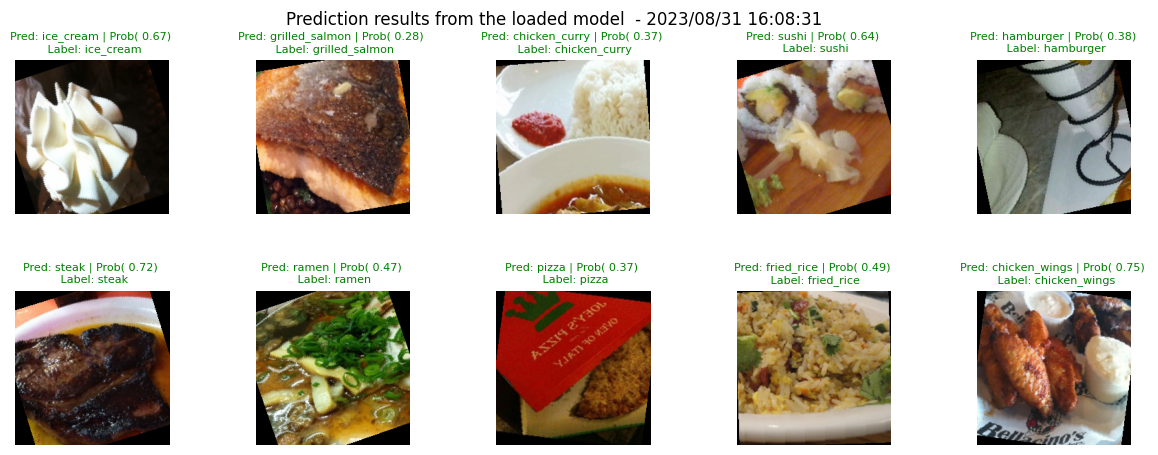

In [13]:
# load a trained model
loaded_model = torch.load(f=MODEL_FILE_PATH)

# evaluate the model with val dataset
loaded_model.eval()
with torch.inference_mode():
    y_logits = loaded_model(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()
    y_probs, _ = torch.max(torch.softmax(y_logits, dim=1), dim=1)
    y_probs = y_probs.cpu().numpy()



# visualize images
plt.figure(figsize=(15,5))
plt.suptitle(f"Prediction results from the loaded model  - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.subplots_adjust(hspace=0.5)
for i, image in enumerate(images):
    plt.subplot(2, len(images) // 2, i + 1)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but Matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0)).numpy()


    # convert the normalization image to a normal image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    plt.imshow(image)

    label = class_names[int(labels[i])]
    predict = class_names[int(y_preds[i])]

    if label == predict:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "g"})
    else:
        plt.title(f"Pred: {predict} | Prob({y_probs[i]: .2f}) \n Label: {label}", fontdict={"fontsize": 8, "color": "r"})
    plt.axis(False)
plt.savefig(PREDICTED_RESULTS_LOADED_FILE_PATH, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

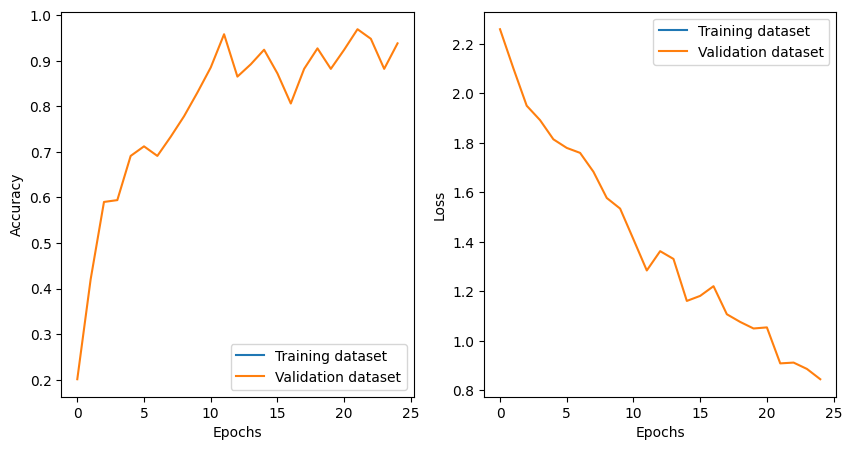

In [14]:
accuracy = history_dict["accuracy"]
loss = history_dict["loss"]
val_accuracy = history_dict["val_accuracy"]
val_loss = history_dict["val_loss"]

# plot history
plt.suptitle(f"History curves from feature-extraction  - {datetime.now().strftime('%Y/%m/%d %H:%m:%S')}")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(list(range(len(accuracy))), accuracy, label="Training dataset")
plt.plot(list(range(len(val_accuracy))), val_accuracy, label="Validation dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(range(len(loss))), loss, label="Training dataset")
plt.plot(list(range(len(val_loss))), val_loss, label="Validation dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(HISTORY_CURVES_FILE_PATH, bbox_inches="tight")